In [3]:
#Analysis 1, only volatility risk 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad


r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.13**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

# Arrays for parameter variations
gamma_vals = np.linspace(0.5, 10, 100)  # Risk aversion
xi_vals = np.linspace(-10, 10, 100)  # Vol-risk premium
V_vals = np.linspace(0.02, 0.3, 100)  # Volatility (in terms of sqrt(V))
sigma_vals = np.linspace(0.02, 0.5, 100)  # Vol of volatility
T_vals = np.linspace(0.1, 10, 100)  # Investment horizon
kappa_vals = np.linspace(0.01, 10, 100)  # Mean reversion rate

# Define functions for A(y) and B(y) as in the appendix
def B(y, a, q, b, t):
    term1 = (a * (1 - np.exp(-q * t))) / (2 * q - (q + b) * (1 - np.exp(-q * t)))
    return -term1

def A(y, kappa_star, v_bar_star, sigma, q, b, tau):
    term1 = kappa_star * v_bar_star / sigma**2
    term2 = (q+b)*tau + 2*np.log(1 - (q + b) / (2 * q) * (1 - np.exp(-q*tau))) 
    return -term1 * term2

# Characteristic function integrands for P1 and P2
def P1_integrand(u, S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    y = 1 - 1j * u

    #Note that a has been adjusted
    a = y*(1-y)
    b = sigma * rho * y - kappa_star
    q = np.sqrt(b**2 + a*sigma**2)
    
    B_val = B(y, a, q, b, T-tau)
    A_val = A(y, kappa_star, v_bar_star, sigma, q, b, tau)
    exponent = A_val + B_val * V + (1j * u) * (np.log(K) - np.log(S) + r * tau)
    return np.imag(np.exp(exponent)) / u

def P2_integrand(u, S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    y = -1j * u

    #Note that a has been adjusted
    a = y*(1-y)
    b = sigma * rho * y - kappa_star
    q = np.sqrt(b**2 + a*sigma**2)

    B_val = B(y, a, q, b, T-tau)
    A_val = A(y, kappa_star, v_bar_star, sigma, q, b, tau)
    exponent = A_val + B_val * V + (1j * u) * (np.log(K) - np.log(S) + r * tau)
    return np.imag(np.exp(exponent)) / u

# Compute P1 and P2
def compute_P1_P2(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    P1 = 0.5 - (1 / np.pi) * quad(P1_integrand, 0, 10000, args=(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu))[0]
    P2 = 0.5 - (1 / np.pi) * quad(P2_integrand, 0, 10000, args=(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu))[0]
    return P1, P2

# European option pricing and delta calculation
def european_option_price_and_delta(S, K, V, r, tau, option_type="call"):
    P1, P2 = compute_P1_P2(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    if option_type == "call":
        price = S * P1 - np.exp(-r * tau) * K * P2
        delta = P1
    elif option_type == "put":
        price = np.exp(-r * tau) * K * (1 - P2) - S * (1 - P1)
        delta = P1-1
    return price, delta

# Calculate delta-neutral straddle
def calculate_straddle_delta(S, K, V, r, tau):
    _, delta_call = european_option_price_and_delta(S, K, V, r, tau, option_type="call")
    _, delta_put = european_option_price_and_delta(S, K, V, r, tau, option_type="put")
    straddle_delta = delta_call + delta_put
    return straddle_delta


# Vega for European option (partial derivative w.r.t. volatility)
def european_option_vega(S, K, V, r, tau, kappa_star, option_type="call"):
    epsilon = 1e-4  # Small change in V for numerical differentiation

    P1_high, P2_high = compute_P1_P2(S, K, V + epsilon, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    P1_low, P2_low = compute_P1_P2(S, K, V - epsilon, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    
    if option_type == "call":
        price_high = S * P1_high - np.exp(-r * tau) * K * P2_high
        price_low = S * P1_low - np.exp(-r * tau) * K * P2_low
    elif option_type == "put":
        price_high = np.exp(-r * tau) * K * (1 - P2_high) - S * (1 - P1_high)
        price_low = np.exp(-r * tau) * K * (1 - P2_low) - S * (1 - P1_low)
    
    # Calculate vega using central difference approximation
    vega = (price_high -price_low) / (2 * epsilon)
    return vega

# Calculate vega-neutral straddle
def calculate_straddle_vega(S, K, V, r, tau):
    vega_call = european_option_vega(S, K, V, r, tau, option_type="call")
    vega_put = european_option_vega(S, K, V, r, tau, option_type="put")
    straddle_vega = vega_call + vega_put
    return straddle_vega

# Compute k1, k2, and delta based on the parameters
def compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa):
    delta = ((1 - gamma) / gamma**2) * (eta**2 + xi**2) 
    #Note that the jump component in delta has been removed
    k1 = kappa - (1 - gamma) / gamma * (eta * rho + xi * np.sqrt(1 - rho**2)) * sigma
    k2 = np.sqrt(k1**2 - delta * sigma**2)
    return k1, k2, delta

#NB. we set delta of the straddle to 0
def phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1, g_s_2, g_v_1, g_v_2, S_paths, O_path_1, O_path_2):
    psi_star=(xi/(gamma*sigma*np.sqrt(1-rho**2))+H(0.1, k1, k2, delta))*(O_path_1+O_path_2)/(g_v_1+g_v_2)
    phi_star=eta/gamma-(xi*rho)/(gamma*np.sqrt(1-rho**2))-psi_star*(0*S_paths)/(O_path_1+O_path_2)
    risk_free=1-psi_star-phi_star

    return phi_star, psi_star, risk_free

# Compute the time-dependent function H(tau)
def H(tau, k1, k2, delta):
    denominator = 2 * k2 + (k1 + k2) * (np.exp(k2 * tau) - 1)
    H_star = ((np.exp(k2*tau)-1) / denominator)*delta
    return H_star

In [4]:

phi_vals_gamma, psi_vals_gamma, riskfree_vals_gamma = [], [], []

r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.15**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

# Loop through each element in loop_array
for gamma in gamma_vals:
        
    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.5
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_gamma.append(phi)
    psi_vals_gamma.append(psi)
    riskfree_vals_gamma.append(riskfree)


In [5]:
phi_vals_xi, psi_vals_xi, riskfree_vals_xi = [], [], []

r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.15**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

# Loop through each element in loop_array
for xi in xi_vals:
        
    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.50
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_xi.append(phi)
    psi_vals_xi.append(psi)
    riskfree_vals_xi.append(riskfree)

In [6]:
phi_vals_V, psi_vals_V, riskfree_vals_V = [], [], []

r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.13**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = V # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

# Loop through each element in loop_array
for V in V_vals:
    V = V**2

    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)

    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        #Volatility process (V_t)
        V_paths[t] = V + kappa * (nu_bar - V) * dt + sigma * np.sqrt(V) * (rho * (dBt[t]-dBt[t-1]) + np.sqrt(1 - rho**2) * (dZt[t]-dZt[t-1])) \
    
        if V_paths[t]<0: 
            V_paths[t]=abs(V_paths[t])

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.5
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_V.append(phi)
    psi_vals_V.append(psi)
    riskfree_vals_V.append(riskfree)


In [7]:
r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.15**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

phi_vals_sigma, psi_vals_sigma, riskfree_vals_sigma = [], [], []

# Loop through each element in loop_array
for sigma in sigma_vals:

    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.50
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_sigma.append(phi)
    psi_vals_sigma.append(psi)
    riskfree_vals_sigma.append(riskfree)


In [8]:
r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.15**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan

phi_vals_T, psi_vals_T, riskfree_vals_T = [], [], []

# Loop through each element in loop_array
for T in T_vals:

    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.50
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_T.append(phi)
    psi_vals_T.append(psi)
    riskfree_vals_T.append(riskfree)


C:\Users\69775\AppData\Local\Temp\ipykernel_16064\2546732133.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  psi_star=(xi/(gamma*sigma*np.sqrt(1-rho**2))+H(0.1, k1, k2, delta))*(O_path_1+O_path_2)/(g_v_1+g_v_2)
C:\Users\69775\AppData\Local\Temp\ipykernel_16064\2546732133.py:133: RuntimeWarning: invalid value encountered in scalar multiply
  phi_star=eta/gamma-(xi*rho)/(gamma*np.sqrt(1-rho**2))-psi_star*(0*S_paths)/(O_path_1+O_path_2)


In [9]:
r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.15**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan
gamma=3 #Liu and Pan (2003)
xi=-6
mu=0
lambda_n=0
lambda_q=0
V_b=0
V=0.15**2
T = 5 # Total time
S0 = 100  # Initial stock price
V0 = V # Initial variance
pi_0 = 1  # Parametric pricing kernel #Liu and Pan


phi_vals_kappa, psi_vals_kappa, riskfree_vals_kappa, kappa_star_vals_kappa, v_bar_star_kappa, P1_kappa, P2_kappa, H_star_kappa = [], [], [], [], [], [], [], []

g_v_1_vals_kappa, g_v_2_vals_kappa, price_1_vals_kappa, price_2_vals_kappa= [], [], [], []


# Loop through each element in loop_array
for kappa in kappa_vals:

    phi_values=[]
    psi_values=[]
    riskfree_values=[]
    g_v_1_values=[]
    g_v_2_values=[]
    price_1_values=[]
    price_2_values=[]
    kappa_star_values=[]
    v_bar_star_values=[]
    P1_values=[]
    P2_values=[]
    H_star_values=[]

    n_steps=100 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
        
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

    # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
        
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        #Volatility process (V_t)
        V_paths[t] = V + kappa * (nu_bar - V) * dt + sigma * np.sqrt(V) * (rho * (dBt[t]-dBt[t-1]) + np.sqrt(1 - rho**2) * (dZt[t]-dZt[t-1])) \
    
        if V_paths[t]<0: 
            V_paths[t]=abs(V_paths[t])

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

    # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    P1 = np.zeros(n_steps)
    P2 = np.zeros(n_steps)
    H_star = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)


    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.50
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
 
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, kappa_star, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)     
        phi, psi, riskfree = phi_psi_riskfree(gamma, eta, rho, xi, sigma, k1, k2, delta, g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], S_paths[t], price_1[t], price_2[t])

        #Compute P1, P2 and H
        P1[t], P2[t] = compute_P1_P2(S_paths[t], S_paths[t], V, r, tau, sigma, rho, kappa_star, lambda_q, mu)
        H_star[t] = H(tau, k1, k2, delta)  

        #append the values in a list
        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(riskfree) 
        g_v_1_values.append(g_v_1) 
        g_v_2_values.append(g_v_2) 
        price_1_values.append(price_1)
        price_2_values.append(price_2)
        kappa_star_values.append(kappa_star)
        v_bar_star_values.append(v_bar_star)
        P1_values.append(P1)
        P2_values.append(P2)
        H_star_values.append(H_star)



    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)
    g_v_1=np.mean(g_v_1_values)
    g_v_2=np.mean(g_v_2_values)
    price_1=np.mean(price_1_values)
    price_2=np.mean(price_2_values)
    kappa_star=np.mean(kappa_star_values)
    v_bar_star=np.mean(v_bar_star_values)
    P1=np.mean(P1_values)
    P2=np.mean(P2_values)
    H_star=np.mean(H_star_values)

    phi_vals_kappa.append(phi)
    psi_vals_kappa.append(psi)
    riskfree_vals_kappa.append(riskfree)
    g_v_1_vals_kappa.append(g_v_1)
    g_v_2_vals_kappa.append(g_v_2)
    price_1_vals_kappa.append(price_1)
    price_2_vals_kappa.append(price_2)
    kappa_star_vals_kappa.append(kappa_star)
    v_bar_star_kappa.append(v_bar_star)
    P1_kappa.append(P1)
    P2_kappa.append(P2)
    H_star_kappa.append(H_star)


# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Kappa': kappa_vals,
    'Phi': phi_vals_kappa,
    'Psi': psi_vals_kappa,
    'Risk-Free Rate': riskfree_vals_kappa,
    'g_v_1': g_v_1_vals_kappa,
    'g_v_2': g_v_2_vals_kappa,
    'Price_1': price_1_vals_kappa,
    'Price_2': price_2_vals_kappa,
    'Kappa_star': kappa_star_vals_kappa,
    'V_bar_star':v_bar_star_kappa,
    'P1':P1_kappa,
    'P2':P2_kappa,
    'H':H_star_kappa
})

# Print the table
print(results_df)

# If using a Jupyter Notebook or a similar environment, you can display the DataFrame directly
try:
    from IPython.display import display
    display(results_df)
except ImportError:
    pass




        Kappa       Phi       Psi  Risk-Free Rate       g_v_1       g_v_2  \
0    0.010000  0.460462 -0.358456        0.897995  128.293610  128.293610   
1    0.110909  0.460462 -0.360197        0.899735  103.790999  103.790999   
2    0.211818  0.460462 -0.361910        0.901449  128.883850  128.883850   
3    0.312727  0.460462 -0.363600        0.903139  148.126526  148.126526   
4    0.413636  0.460462 -0.365270        0.904809  104.762422  104.762422   
..        ...       ...       ...             ...         ...         ...   
95   9.596364  0.460462 -0.549790        1.089328   42.670569   42.670569   
96   9.697273  0.460462 -0.552375        1.091913   68.395344   68.395344   
97   9.798182  0.460462 -0.554971        1.094509   44.889461   44.889461   
98   9.899091  0.460462 -0.557577        1.097116   64.915120   64.915120   
99  10.000000  0.460462 -0.560195        1.099733   49.635327   49.635327   

     Price_1   Price_2  Kappa_star  V_bar_star        P1        P2         

,Kappa,Phi,Psi,Risk-Free Rate,g_v_1,g_v_2,Price_1,Price_2,Kappa_star,V_bar_star,P1,P2,H
0,0.010000,0.460462,-0.358456,0.897995,128.293610,128.293610,5.268494,4.577309,2.184824,0.000103,0.553183,0.518131,-0.606517
1,0.110909,0.460462,-0.360197,0.899735,103.790999,103.790999,4.289364,3.717333,2.285733,0.001092,0.551461,0.517014,-0.603410
2,0.211818,0.460462,-0.361910,0.901449,128.883850,128.883850,5.359587,4.633518,2.386642,0.001997,0.549802,0.515927,-0.600324
3,0.312727,0.460462,-0.363600,0.903139,148.126526,148.126526,6.197453,5.345136,2.487551,0.002829,0.548202,0.514867,-0.597258
4,0.413636,0.460462,-0.365270,0.904809,104.762422,104.762422,4.409439,3.794185,2.588460,0.003596,0.546658,0.513833,-0.594213
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.596364,0.460462,-0.549790,1.089328,42.670569,42.670569,2.893331,2.251446,11.771188,0.018343,0.488945,0.469028,-0.386605
96,9.697273,0.460462,-0.552375,1.091913,68.395344,68.395344,4.661338,3.625600,11.872097,0.018378,0.488694,0.468810,-0.384930
97,9.798182,0.460462,-0.554971,1.094509,44.889461,44.889461,3.074809,2.390544,11.973006,0.018413,0.488446,0.468596,-0.383267
98,9.899091,0.460462,-0.557577,1.097116,64.915120,64.915120,4.469152,3.473093,12.073915,0.018447,0.488203,0.468384,-0.381613


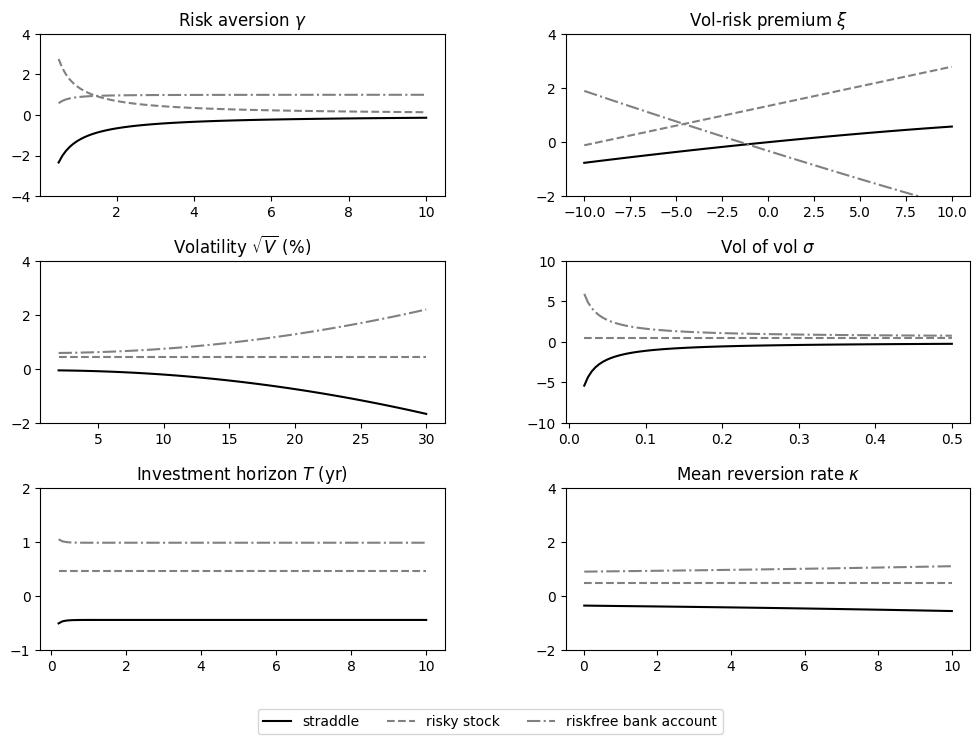

In [10]:
# Generate subplots for each parameter variation
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Varying risk aversion gamma
l1, = axs[0, 0].plot(gamma_vals, psi_vals_gamma, color='black', label='straddle')
l2, = axs[0, 0].plot(gamma_vals, phi_vals_gamma, linestyle='--', color='gray', label='risky stock')
l3, = axs[0, 0].plot(gamma_vals, riskfree_vals_gamma, linestyle='-.', color='gray', label='riskfree bank account')
axs[0, 0].set_title('Risk aversion $\\gamma$')
axs[0, 0].set_ylim(-4, 4) 

# 2. Varying vol-risk premium xi
axs[0, 1].plot(xi_vals, psi_vals_xi, color='black')
axs[0, 1].plot(xi_vals, phi_vals_xi, linestyle='--', color='gray')
axs[0, 1].plot(xi_vals, riskfree_vals_xi, linestyle='-.', color='gray')
axs[0, 1].set_title('Vol-risk premium $\\xi$')
axs[0, 1].set_ylim(-2, 4) 

# 3. Varying volatility sqrt(V)
axs[1, 0].plot(V_vals * 100, psi_vals_V, color='black')
axs[1, 0].plot(V_vals * 100, phi_vals_V, linestyle='--', color='gray')
axs[1, 0].plot(V_vals * 100, riskfree_vals_V, linestyle='-.', color='gray')
axs[1, 0].set_title('Volatility $\\sqrt{V}$ (%)')
axs[1, 0].set_ylim(-2, 4) 

# 4. Varying volatility of volatility sigma
axs[1, 1].plot(sigma_vals, psi_vals_sigma, color='black')
axs[1, 1].plot(sigma_vals, phi_vals_sigma, linestyle='--', color='gray')
axs[1, 1].plot(sigma_vals, riskfree_vals_sigma, linestyle='-.', color='gray')
axs[1, 1].set_title('Vol of vol $\\sigma$')
axs[1, 1].set_ylim(-10, 10) 

# 5. Varying investment horizon T
axs[2, 0].plot(T_vals, psi_vals_T, color='black')
axs[2, 0].plot(T_vals, phi_vals_T, linestyle='--', color='gray')
axs[2, 0].plot(T_vals, riskfree_vals_T, linestyle='-.', color='gray')
axs[2, 0].set_title('Investment horizon $T$ (yr)')
axs[2, 0].set_ylim(-1, 2) 

# 6. Varying mean reversion rate kappa
axs[2, 1].plot(kappa_vals, psi_vals_kappa, color='black')
axs[2, 1].plot(kappa_vals, phi_vals_kappa, linestyle='--', color='gray')
axs[2, 1].plot(kappa_vals, riskfree_vals_kappa, linestyle='-.', color='gray')
axs[2, 1].set_title('Mean reversion rate $\\kappa$')
axs[2, 1].set_ylim(-2, 4)

# Create a single legend
fig.legend([l1, l2, l3], ['straddle', 'risky stock', 'riskfree bank account'], loc='lower center', ncol=3)

plt.show()

